# Models

In [1]:
#!pip install seaborn
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

In [2]:
df = pd.read_csv("local-olives-cleaned.csv")
df.head()

,areastring,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic,regionstring
0,North-Apulia,1,1,10.75,0.75,2.26,78.23,6.72,0.36,0.60,0.29,South
1,North-Apulia,1,1,10.88,0.73,2.24,77.09,7.81,0.31,0.61,0.29,South
2,North-Apulia,1,1,9.11,0.54,2.46,81.13,5.49,0.31,0.63,0.29,South
3,North-Apulia,1,1,9.66,0.57,2.40,79.52,6.19,0.50,0.78,0.35,South
4,North-Apulia,1,1,10.51,0.67,2.59,77.71,6.72,0.50,0.80,0.46,South


In [3]:
acidlist=['palmitic', 'palmitoleic', 'stearic', 'oleic', 'linoleic', 'linolenic', 'arachidic', 'eicosenoic']

In [4]:
dfsouth=df[df.regionstring=='South']
dfsouth.head()

,areastring,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic,regionstring
0,North-Apulia,1,1,10.75,0.75,2.26,78.23,6.72,0.36,0.60,0.29,South
1,North-Apulia,1,1,10.88,0.73,2.24,77.09,7.81,0.31,0.61,0.29,South
2,North-Apulia,1,1,9.11,0.54,2.46,81.13,5.49,0.31,0.63,0.29,South
3,North-Apulia,1,1,9.66,0.57,2.40,79.52,6.19,0.50,0.78,0.35,South
4,North-Apulia,1,1,10.51,0.67,2.59,77.71,6.72,0.50,0.80,0.46,South


## Predicting via SVM

In [46]:
dfnew=df[['eicosenoic', 'region', 'regionstring']]
dfnew['linoarch']=(0.969/1022.0)*df.linoleic + (0.245/105.0)*df.arachidic
dfnew.head()

,eicosenoic,region,regionstring,linoarch
0,0.29,1,South,0.007772
1,0.29,1,South,0.008828
2,0.29,1,South,0.006675
3,0.35,1,South,0.007689
4,0.46,1,South,0.008238


In [5]:
dfnosouth=df[df.regionstring!='South']
dfnosouth.head()

,areastring,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic,regionstring
323,Inland-Sardinia,2,5,11.29,1.20,2.22,72.72,11.12,0.43,0.98,0.02,Sardinia
324,Inland-Sardinia,2,5,10.42,1.35,2.10,73.76,11.16,0.35,0.90,0.03,Sardinia
325,Inland-Sardinia,2,5,11.03,0.96,2.10,73.80,10.85,0.32,0.94,0.03,Sardinia
326,Inland-Sardinia,2,5,11.18,0.97,2.21,72.79,11.54,0.35,0.94,0.02,Sardinia
327,Inland-Sardinia,2,5,10.52,0.95,2.15,73.88,11.26,0.31,0.92,0.01,Sardinia


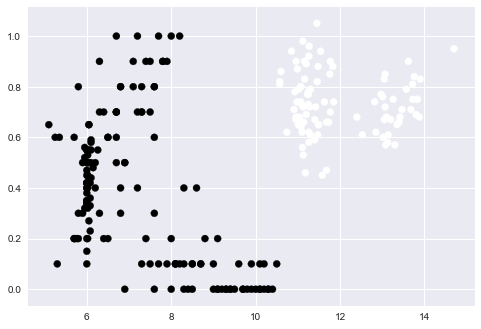

In [7]:
plt.scatter(dfnosouth.linoleic, dfnosouth.arachidic, c=dfnosouth.region, s=50);

In [20]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC # "Support Vector Classifier"

def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([[xi, yj]])
    return ax.contour(X, Y, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])


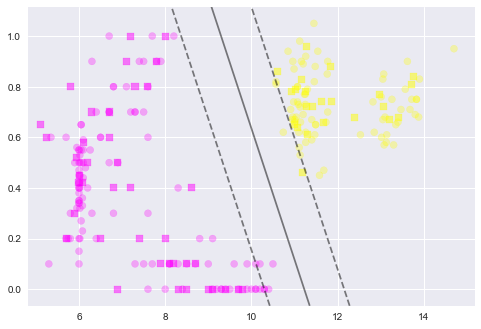

In [23]:
X = dfnosouth[['linoleic', 'arachidic']]
y = (dfnosouth.regionstring.values=='Sardinia')*1
Xtrain, Xtest, ytrain, ytest = train_test_split(X.values ,y)
clf = SVC(kernel="linear")
clf.fit(Xtrain, ytrain)
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=ytrain, s=50, cmap='spring', alpha=0.3)
plot_svc_decision_function(clf, plt.gca())
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
plt.scatter(Xtest[:, 0], Xtest[:, 1], c=ytest, s=50, marker="s", cmap='spring', alpha=0.5);

In [24]:
clf.score(Xtest, ytest)

1.0

In [57]:
confusion_matrix(clf.predict(Xtest), ytest)

array([[31,  0],
       [ 0, 32]])

## Allowing for crossovers

In [28]:
from sklearn.model_selection import GridSearchCV
def cv_optimize_svm(X, y, n_folds=10, num_p=50):
    #clf = SVC()
    #parameters = {"C": np.logspace(-4, 3, num=num_p), "gamma": np.logspace(-4, 3, num=10)}
    clf = SVC(kernel="linear", probability=True)
    parameters = {"C": np.logspace(-4, 3, num=num_p)}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    return gs

def get_optim_classifier_svm(indf, inacidlist, clon, clonval):
    subdf=indf[inacidlist]
    subdfstd=(subdf - subdf.mean())/subdf.std()
    X=subdfstd.values
    y=(indf[clon].values==clonval)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)
    #Xtrain, Xtest, ytrain, ytest=X,X,y,y
    fitted=cv_optimize_svm(Xtrain, ytrain)
    return fitted, Xtrain, ytrain, Xtest, ytest

In [29]:
thesvcfit, Xtr, ytr, Xte, yte = get_optim_classifier_svm(dfnosouth, ['linoleic','arachidic'],'regionstring', "Sardinia")
#thesvcfit, Xtr, ytr, Xte, yte = get_optim_classifier_binary(dfsouthns, ['palmitic','palmitoleic'],'area', 3)
thesvcfit.best_estimator_, thesvcfit.best_params_, thesvcfit.best_score_

(SVC(C=0.071968567300115138, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
   max_iter=-1, probability=True, random_state=None, shrinking=True,
   tol=0.001, verbose=False), {'C': 0.071968567300115138}, 1.0)

{'kernel': 'linear', 'C': 0.071968567300115138}


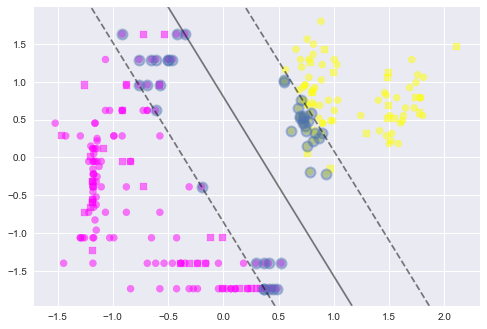

In [45]:
def plot_svm_new(clf,Xtr,ytr,Xte,yte):
    plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr, s=50, cmap='spring', alpha=0.5)
    plt.scatter(Xte[:, 0], Xte[:, 1], marker='s', c=yte, s=50, cmap='spring', alpha=0.5)

    #plt.xlim(-1, 4)
    #plt.ylim(-1, 6)
    plot_svc_decision_function(clf, plt.gca())
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=100, facecolors=None , lw=2, alpha=0.4)
print(dict(kernel="linear",**thesvcfit.best_params_))
clsvc=SVC(**dict(kernel="linear",**thesvcfit.best_params_)).fit(Xtr, ytr)
plot_svm_new(clsvc, Xtr, ytr, Xte, yte)

The best fit allows for a bigger margin by allowing some inbetween penalization. If we use the standard C=1 in scikit-learn you see that we are allowing for less penalization.